## Note:

Due to intrinsic stochasticity in the underlying algorithms, results may differ slightly between runs.

## Import libraries

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner_py3 as miner
%matplotlib inline
plt.style.use('ggplot')

## Create directory to save output files

In [3]:
# Path to the miner directory
input_path = os.path.join(os.path.expanduser('~'),'Desktop','GitHub','miner','miner')

# create name for results folder where output files will be saved
resultsFolder = "results_miner3_stabilized"

# name of the folder containing the miner network
#networkFolder = "miner_network_results"
networkFolder = "results_minCorrelation_0o2_50_allFiles"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load primary data

In [4]:
# Load expression Data
expressionFile = os.path.join(input_path,"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path,'data','mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path,'data','mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path,'data','mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(input_path,networkFolder,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(input_path,networkFolder,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(input_path,networkFolder,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,networkFolder,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

completed identifier conversion.
16216 genes were converted.


## Load network

In [5]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

In [6]:
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

## Load primary survival data

In [7]:
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(input_path,"data","survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

## Infer nework-constrained gene activity

In [8]:
network_activity_overexpressed = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=overExpressedMembersMatrix.copy(),
                                                 minRegulons = 2)
network_activity_underexpressed = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=underExpressedMembersMatrix.copy(),
                                                 minRegulons = 2)
network_activity_diff = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=diff_matrix_MMRF.copy(),
                                                 minRegulons = 2)

## Compare predictive power of individual features

In [9]:
# Define subtypes
subtypes = {"Del 17":miner.getMutations("del17",cytogenetics),
            "Amp 1q":miner.getMutations("amp1q",cytogenetics),
            "t(4;14)":miner.getMutations("RNASeq_WHSC1_Call",translocations),
            "t(14;16)":miner.getMutations("RNASeq_MAF_Call",translocations),
            "MYC":miner.getMutations("RNASeq_MYC_Call",translocations)}

# Define survival dataset
srv = guanSurvivalDfMMRF

# Number of bootstrap iterations to be performed
n_iter = 500

# Set thresholds for high- and low-risk groups
hr_prop = 0.30
lr_prop = 0.70

Iterating subtype Del 17
Iterating subtype Amp 1q
Iterating subtype t(4;14)
Iterating subtype t(14;16)
Iterating subtype MYC


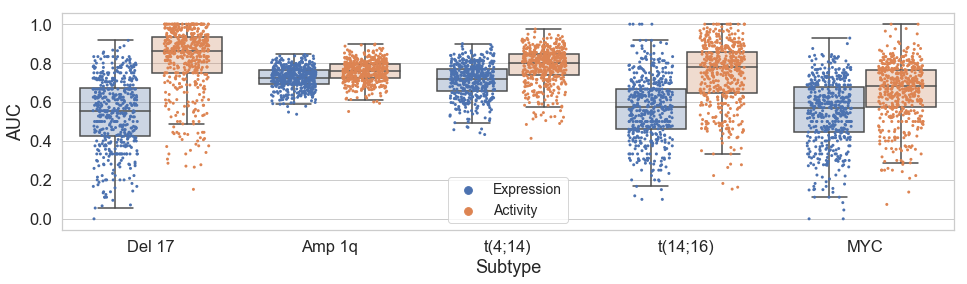

In [10]:
# Compare bootstrapped AUCs from predictions using 
# the expression vs. network activity of single genes
univariate_comparison_df, univ_data, univ_fig = miner.univariate_comparison(subtypes,srv,expressionData,network_activity_diff,
                                                                            n_iter = 500,hr_prop = 0.30,lr_prop = 0.70,
                                                                            results_directory = resultsDirectory)

## Stratify risk based upon univariate features

F1 score: 0.53
F1 score: 0.46
F1 score: 0.48
F1 score: 0.59
F1 score: 0.75


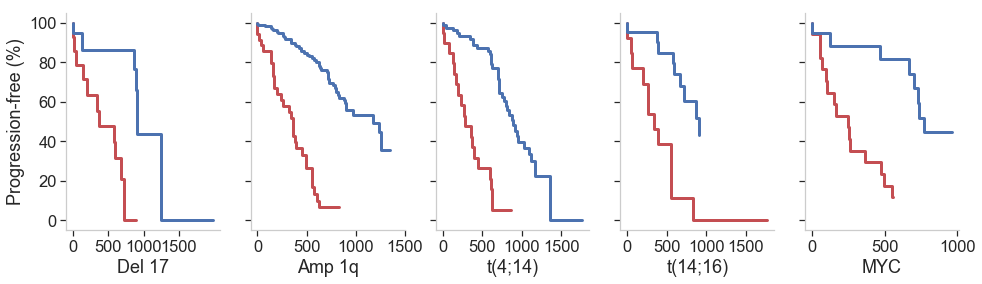

In [17]:
# Optimize thresholds for network activity of predictive genes
optimized_survival_parameters = miner.optimize_survival_parameters(univ_data,
                                  network_activity_diff,subtypes,srv,abs_threshold=0.25)
 
# Plot subtype survival
survival_figure = miner.univariate_survival(subtypes,optimized_survival_parameters,network_activity_diff,srv,results_directory=resultsDirectory)

## Infer states from network activity

In [44]:
# Infer transcriptional states
minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
referenceMatrix = network_activity_overexpressed-network_activity_underexpressed
primaryMatrix = network_activity_overexpressed
primaryDictionary = miner.matrix_to_dictionary(primaryMatrix,threshold=0.5)
secondaryMatrix = network_activity_underexpressed
secondaryDictionary = miner.matrix_to_dictionary(secondaryMatrix,threshold=0.5)

np.random.seed(12)
inferred_states, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = int(np.ceil(0.01*primaryMatrix.shape[1])),restricted_index=None)
states_dictionary = {str(i):inferred_states[i] for i in range(len(inferred_states))}
print(len(inferred_states),len(np.hstack(inferred_states)))

Beginning subtype inference
completed subtype inference in 1.48 minutes
29 881


## Infer genetic programs from network activity

In [19]:
# Infer gene clusters
states = inferred_states.copy() #states_list.copy()
dfr = network_activity_diff.copy()
minClusterSize_x = 9
minClusterSize_y = 6
max_groups = 50
allow_singletons = False
random_state = 12

# Cluster genes using original transcriptional states
gene_clusters, gene_groups = miner.cluster_features(dfr,states,minClusterSize_x,minClusterSize_y,
                    max_groups,allow_singletons,random_state)

Completed clustering in 3.02 minutes


## Integrate all plots into figure

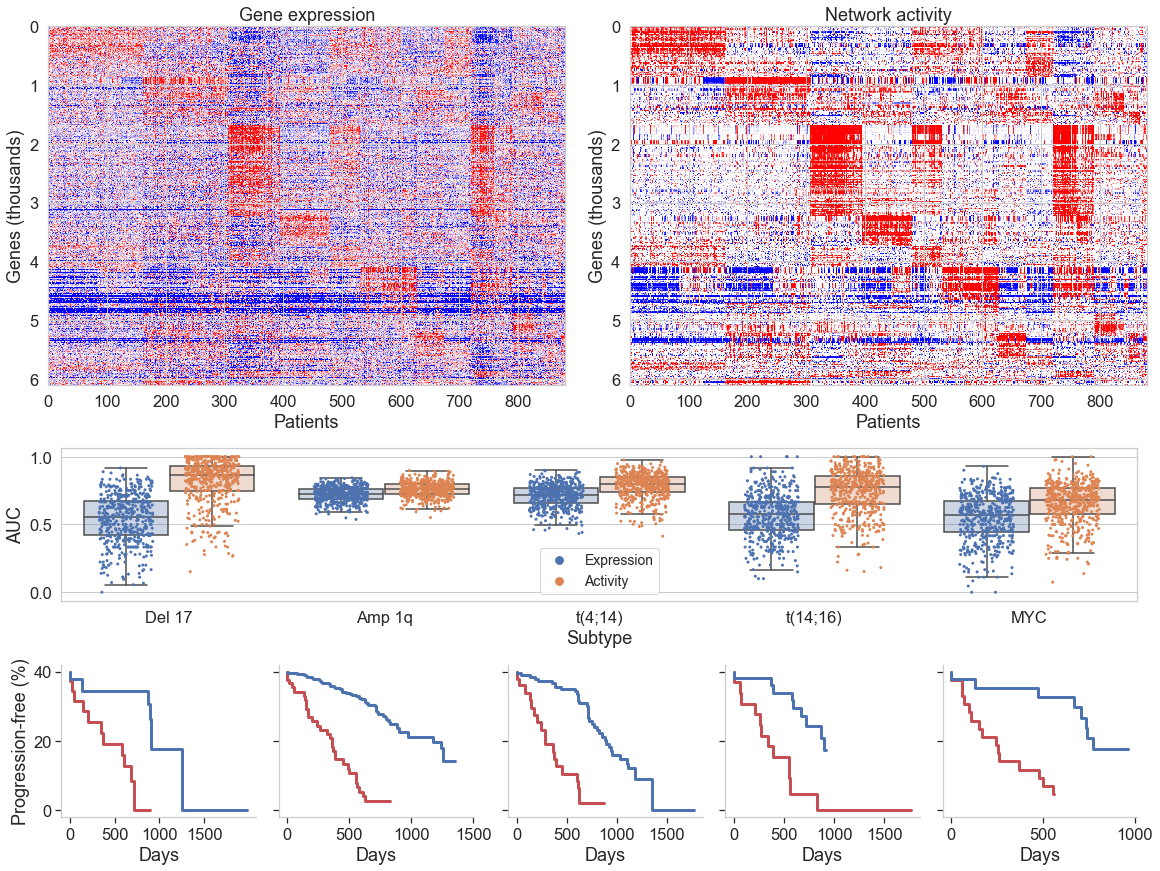

In [50]:
importlib.reload(miner)
fig3, hr_groups, lr_groups = miner.composite_survival_figure(univariate_comparison_df,subtypes,
                             optimized_survival_parameters,network_activity_diff,
                             expressionData,srv,gene_clusters,inferred_states,
                             results_directory=resultsDirectory)

## Survival plot of sub-stratified high-risk groups

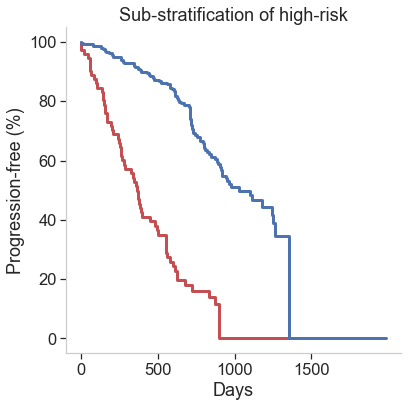

In [24]:
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_ylim(-0.05,1.05)
ax.grid(color='w', linestyle='--', linewidth=1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

timeline = list(srv.loc[np.hstack([hr_groups, lr_groups]),srv.columns[0]])
max_time = max(timeline)
ax.set_xticks(np.arange(0, max_time, 500))
ax.set_xlabel("Days")
ax.set_ylabel("Progression-free (%)")
ax.set_yticklabels(np.arange(-20, 120, 20))
ax.set_title("Sub-stratification of high-risk")

groups = [hr_groups,lr_groups]
miner.kmplot(srv,groups,labels = ["Activated","Inactivated"],
             xlim_=None,filename=None,color=["r","b"],lw=3,alpha=1,fs=20)



## Write network activity to file

In [48]:
# Network activity
network_activity_diff.to_csv(os.path.join(resultsDirectory,"network_activity.csv"))

# Gene expression
expressionData.loc[network_activity_diff.index,:].to_csv(os.path.join(resultsDirectory,"gene_expression_mmrf.csv"))